In [39]:
from dendrocat import RadioSource, MasterCatalog
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from regions import Regions, PixCoord
from astropy import stats
from itertools import chain
import dendrocat
from scipy import stats
import Paths.Paths as paths
Path = paths.filepaths()









In [46]:
from astropy.nddata.utils import Cutout2D, NoOverlapError
from astropy import coordinates, wcs
import astropy.units as u
from matplotlib import colors
from matplotlib.patches import Rectangle, Ellipse
from radio_beam import Beam
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

def get_cutout(image_dir, xpos, ypos, fwhm):
    fitsdata = fits.open(image_dir)
    wcs_image = WCS(fitsdata[0].header,naxis=2)
    image = fitsdata[0].data[0][0]
    if len(image.shape)>2:
        image = fitsdata[0].data[0][0]
    x_cen = xpos * u.deg
    y_cen = ypos * u.deg
    position = coordinates.SkyCoord(x_cen, y_cen,
                                    frame=wcs.utils.wcs_to_celestial_frame(wcs_image).name,
                                    unit=(u.deg, u.deg))
    pixel_scale = (np.abs(wcs_image.pixel_scale_matrix.diagonal().prod())**0.5 * u.deg)
    size = 10*fwhm
        #size = 24*pixel_scale + 2.5*fwhm * u.deg
    
    cutout = Cutout2D(image,
                          position,
                      size,
                      wcs=wcs_image,
                      mode='partial')
     

  
    return cutout

def add_scale_bar(ax, xpos,ypos,scale, pixel_scale, dist, unit='pc',height=20,color='w',pad=40,size=40):
    phy_pix_scale = pixel_scale.value * np.pi/180 * dist
    ax.add_patch(Rectangle((xpos,ypos),scale/phy_pix_scale,height,color=color))
    ax.text(xpos+0.4*scale/phy_pix_scale, ypos+pad, '%2.1f %s'%(scale, unit), color=color,fontsize=size)
                
def add_beam(ax,xpos,ypos,beam, pixel_scale,color='w'):
    width = beam.major / pixel_scale
    height = beam.minor /pixel_scale
    angle = beam.pa
    ax.add_patch(Ellipse((xpos,ypos),width.value,height.value,180-angle.value,color=color))

def plot_cutouts(ax, image_dir, xpos, ypos, fwhm, cmap='inferno', 
                 addbeam=True, scale=None, dist=None, 
                 vmin=-0.00010907209521789237, vmax=0.01065474459299, sqrtpower=True,
                label=None, mmlabel=None, fontcolor='k',radec=None,  backgroundcolor='w'
                ):
    
    cutout = get_cutout(image_dir, xpos, ypos, fwhm)
    shape = cutout.data.shape
    hdr = fits.getheader(image_dir)  
    wcs = WCS(hdr,naxis=2)
    pixel_scale = wcs.proj_plane_pixel_scales()[0]
    beam = Beam.from_fits_header(hdr)
    midpoint = int(shape[0]/2)

    beamsize_pix = beam.major.to(u.deg).value / pixel_scale

    if sqrtpower:
        vmax = np.nanmax(cutout.data[midpoint-int(2*beamsize_pix.value):midpoint+int(2*beamsize_pix.value), midpoint-int(2*beamsize_pix.value):midpoint+int(2*beamsize_pix.value)])
        ax.imshow(cutout.data, origin='lower', cmap=plt.get_cmap(cmap), 
              norm=colors.PowerNorm(gamma=0.5, vmin=np.min(cutout.data[np.isfinite(cutout.data)]), 
                                    vmax=1.5*vmax),aspect='equal')
    else:
        
        ax.imshow(cutout.data, origin='lower', cmap=plt.get_cmap(cmap), 
              vmin=vmin, vmax=vmax,aspect='auto')
    if addbeam:
        add_beam(ax, 0.15*shape[0], 0.15*shape[1], beam, pixel_scale)
    if scale is not None:
        add_scale_bar(ax, 0.8*shape[0], 0.2*shape[1], scale, pixel_scale, dist)
    if label is not None:
        ax.text(0.08*shape[0],0.85*shape[1], label, color=fontcolor, fontsize=35, backgroundcolor=backgroundcolor)
    if radec is not None:
        ax.text(0.08*shape[0],0.87*shape[1], f'RA={radec[0]:.5f} deg', color=fontcolor, fontsize=25, backgroundcolor=backgroundcolor)
        ax.text(0.08*shape[0],0.78*shape[1], f'DEC={radec[1]:.5f} deg', color=fontcolor, fontsize=25, backgroundcolor=backgroundcolor)
        
    #if mmlabel is not None:
    #    ax.text(0.65*shape[0],0.85*shape[1], mmlabel, color=mmlabelcolor, fontsize=25)
    ax.set_xticks([])
    ax.set_yticks([])
    return cutout.data


def plot_set_cutouts(table_fin, b3file, b6file, savedir='', 
startnum=0,  nrow=9, ncol=4, margin = 0.01, top = 0.98, bottom = 0.02,
wspace=0.00, hspace=0.00, additional_row=0, endnum=None):
    
    hdr_b3 = fits.getheader(b3file)
    hdr_b6 = fits.getheader(b6file)

    beam_b3 = Beam.from_fits_header(hdr_b3)    
    beam_b6 = Beam.from_fits_header(hdr_b6)
    size = (beam_b3.major+beam_b6.major)/2   

    if endnum is None:
        endnum = len(table_fin['ra'])
    endendnum = len(table_fin['ra'])
    print('endnum', endnum)
    print('endendnum', endendnum)
    width = (1 - margin*ncol)/ncol
    height = (top-bottom-5*margin)/(nrow+additional_row)
    ratio = width/2/height
    bottom = top - height * nrow
    figsize=40
    fig = plt.figure(figsize=(figsize,figsize*ratio))
    if nrow >0:
        for icol in range(ncol):
            gs = GridSpec(nrow, 2, left=(icol+1)*margin+icol*width, right=(icol+1)*(margin+width), 
                        wspace=wspace, hspace=hspace, top=top, bottom=bottom)
            for irow in range(nrow):
                obsnum = icol * nrow + irow + startnum
                print('obsnum',obsnum)
                if obsnum > endnum:
                    continue
                obsnum_final = obsnum
                ax1 = fig.add_subplot(gs[irow,0])
                ax2 = fig.add_subplot(gs[irow,1])
                ax1.set_aspect('auto')
                ax2.set_aspect('auto')
                ax1.xaxis.set_major_locator(plt.NullLocator())
                ax1.yaxis.set_major_locator(plt.NullLocator())
                ax2.xaxis.set_major_locator(plt.NullLocator())
                ax2.yaxis.set_major_locator(plt.NullLocator())

                ra = table_fin['ra'][obsnum]
                dec = table_fin['dec'][obsnum]
                overlap = table_fin['is_overlap'][obsnum]

                if irow == 0:
                    ax1.set_title('3 mm', fontsize=40)
                    ax2.set_title('1.3 mm', fontsize=40)

               
               
               
                #print(obsnum, xpos_b3, ypos_b3, xpos_b6, ypos_b6, b3id, b6id)
                
            
                
                
                b3arr = plot_cutouts(ax1, b3file,ra, dec, size,label='#%d'%(obsnum), mmlabel='3 mm', fontcolor='k')
                    
                if overlap:
                    b6arr = plot_cutouts(ax2, b6file, ra,dec, size, mmlabel='1.3 mm', radec=(ra, dec), fontcolor='k')
                if not table_fin['isdetected_b3'][obsnum]:
                    rect = patches.Rectangle((0.02*b3arr.shape[1], 0.02*b3arr.shape[0]), 0.96*b3arr.shape[1], 0.96*b3arr.shape[0], linewidth=30, edgecolor='cyan', facecolor='none')
                    ax1.add_patch(rect)

                if not table_fin['isdetected_b6'][obsnum]:
                    rect = patches.Rectangle((0.02*b6arr.shape[1], 0.02*b6arr.shape[0]), 0.96*b6arr.shape[1], 0.96*b6arr.shape[0], linewidth=30, edgecolor='cyan', facecolor='none')
                    ax2.add_patch(rect)
        print('obsnum_final, endnum',obsnum_final, endnum)
        print('endnum',endnum)   
    if additional_row > 0:
        top_add = bottom - 5*margin
        bottom_add = top_add - additional_row * height
        print('height',height)
        print('top_add', top_add)
        print('bottom_add', bottom_add)
        print('margin', margin)
        gs_add = GridSpec(additional_row, ncol*2, left=margin, right=1-margin,wspace=0.0, hspace=0.0, top=top_add, bottom=bottom_add)
        print('endnum', endnum)
        print('endendnum', endendnum)
        arr = np.arange(endnum+1, endendnum)
        print('arr', arr)
        for num in arr:
            ind = num - endnum - 1

            xind = ind % (ncol*2) 
            yind = ind // (ncol*2)
            print('ind, xind, yind', ind, xind, yind)
            ax = fig.add_subplot(gs_add[yind,xind])
            if ind==0:
                ax.set_title('3 mm', fontsize=40)
            #ax.set_aspect('auto')
            ax.xaxis.set_major_locator(plt.NullLocator())
            ax.yaxis.set_major_locator(plt.NullLocator())
            ra = table_fin['ra'][obsnum]
            dec = table_fin['dec'][obsnum]
            b3arr = plot_cutouts(ax, b3file, ra, dec, size,label='#%d'%(num), mmlabel='3 mm', fontcolor='k')
                



    print('plot saved to ', savedir)
    plt.savefig(savedir)
    

  

45
endnum 45
endendnum 45
obsnum 0
obsnum 1
obsnum 2
obsnum 3
obsnum 4
obsnum 5
obsnum 6
obsnum 7
obsnum 8
obsnum 9
obsnum 10
obsnum 11
obsnum 12
obsnum 13
obsnum 14
obsnum 15
obsnum 16
obsnum 17
obsnum 18
obsnum 19
obsnum 20
obsnum 21
obsnum 22
obsnum 23
obsnum 24
obsnum 25
obsnum 26
obsnum 27
obsnum 28
obsnum 29
obsnum 30
obsnum 31
obsnum 32
obsnum 33
obsnum 34
obsnum 35
obsnum_final, endnum 35 45
endnum 45
plot saved to  w51e_snapshot_ambiguous-1.png


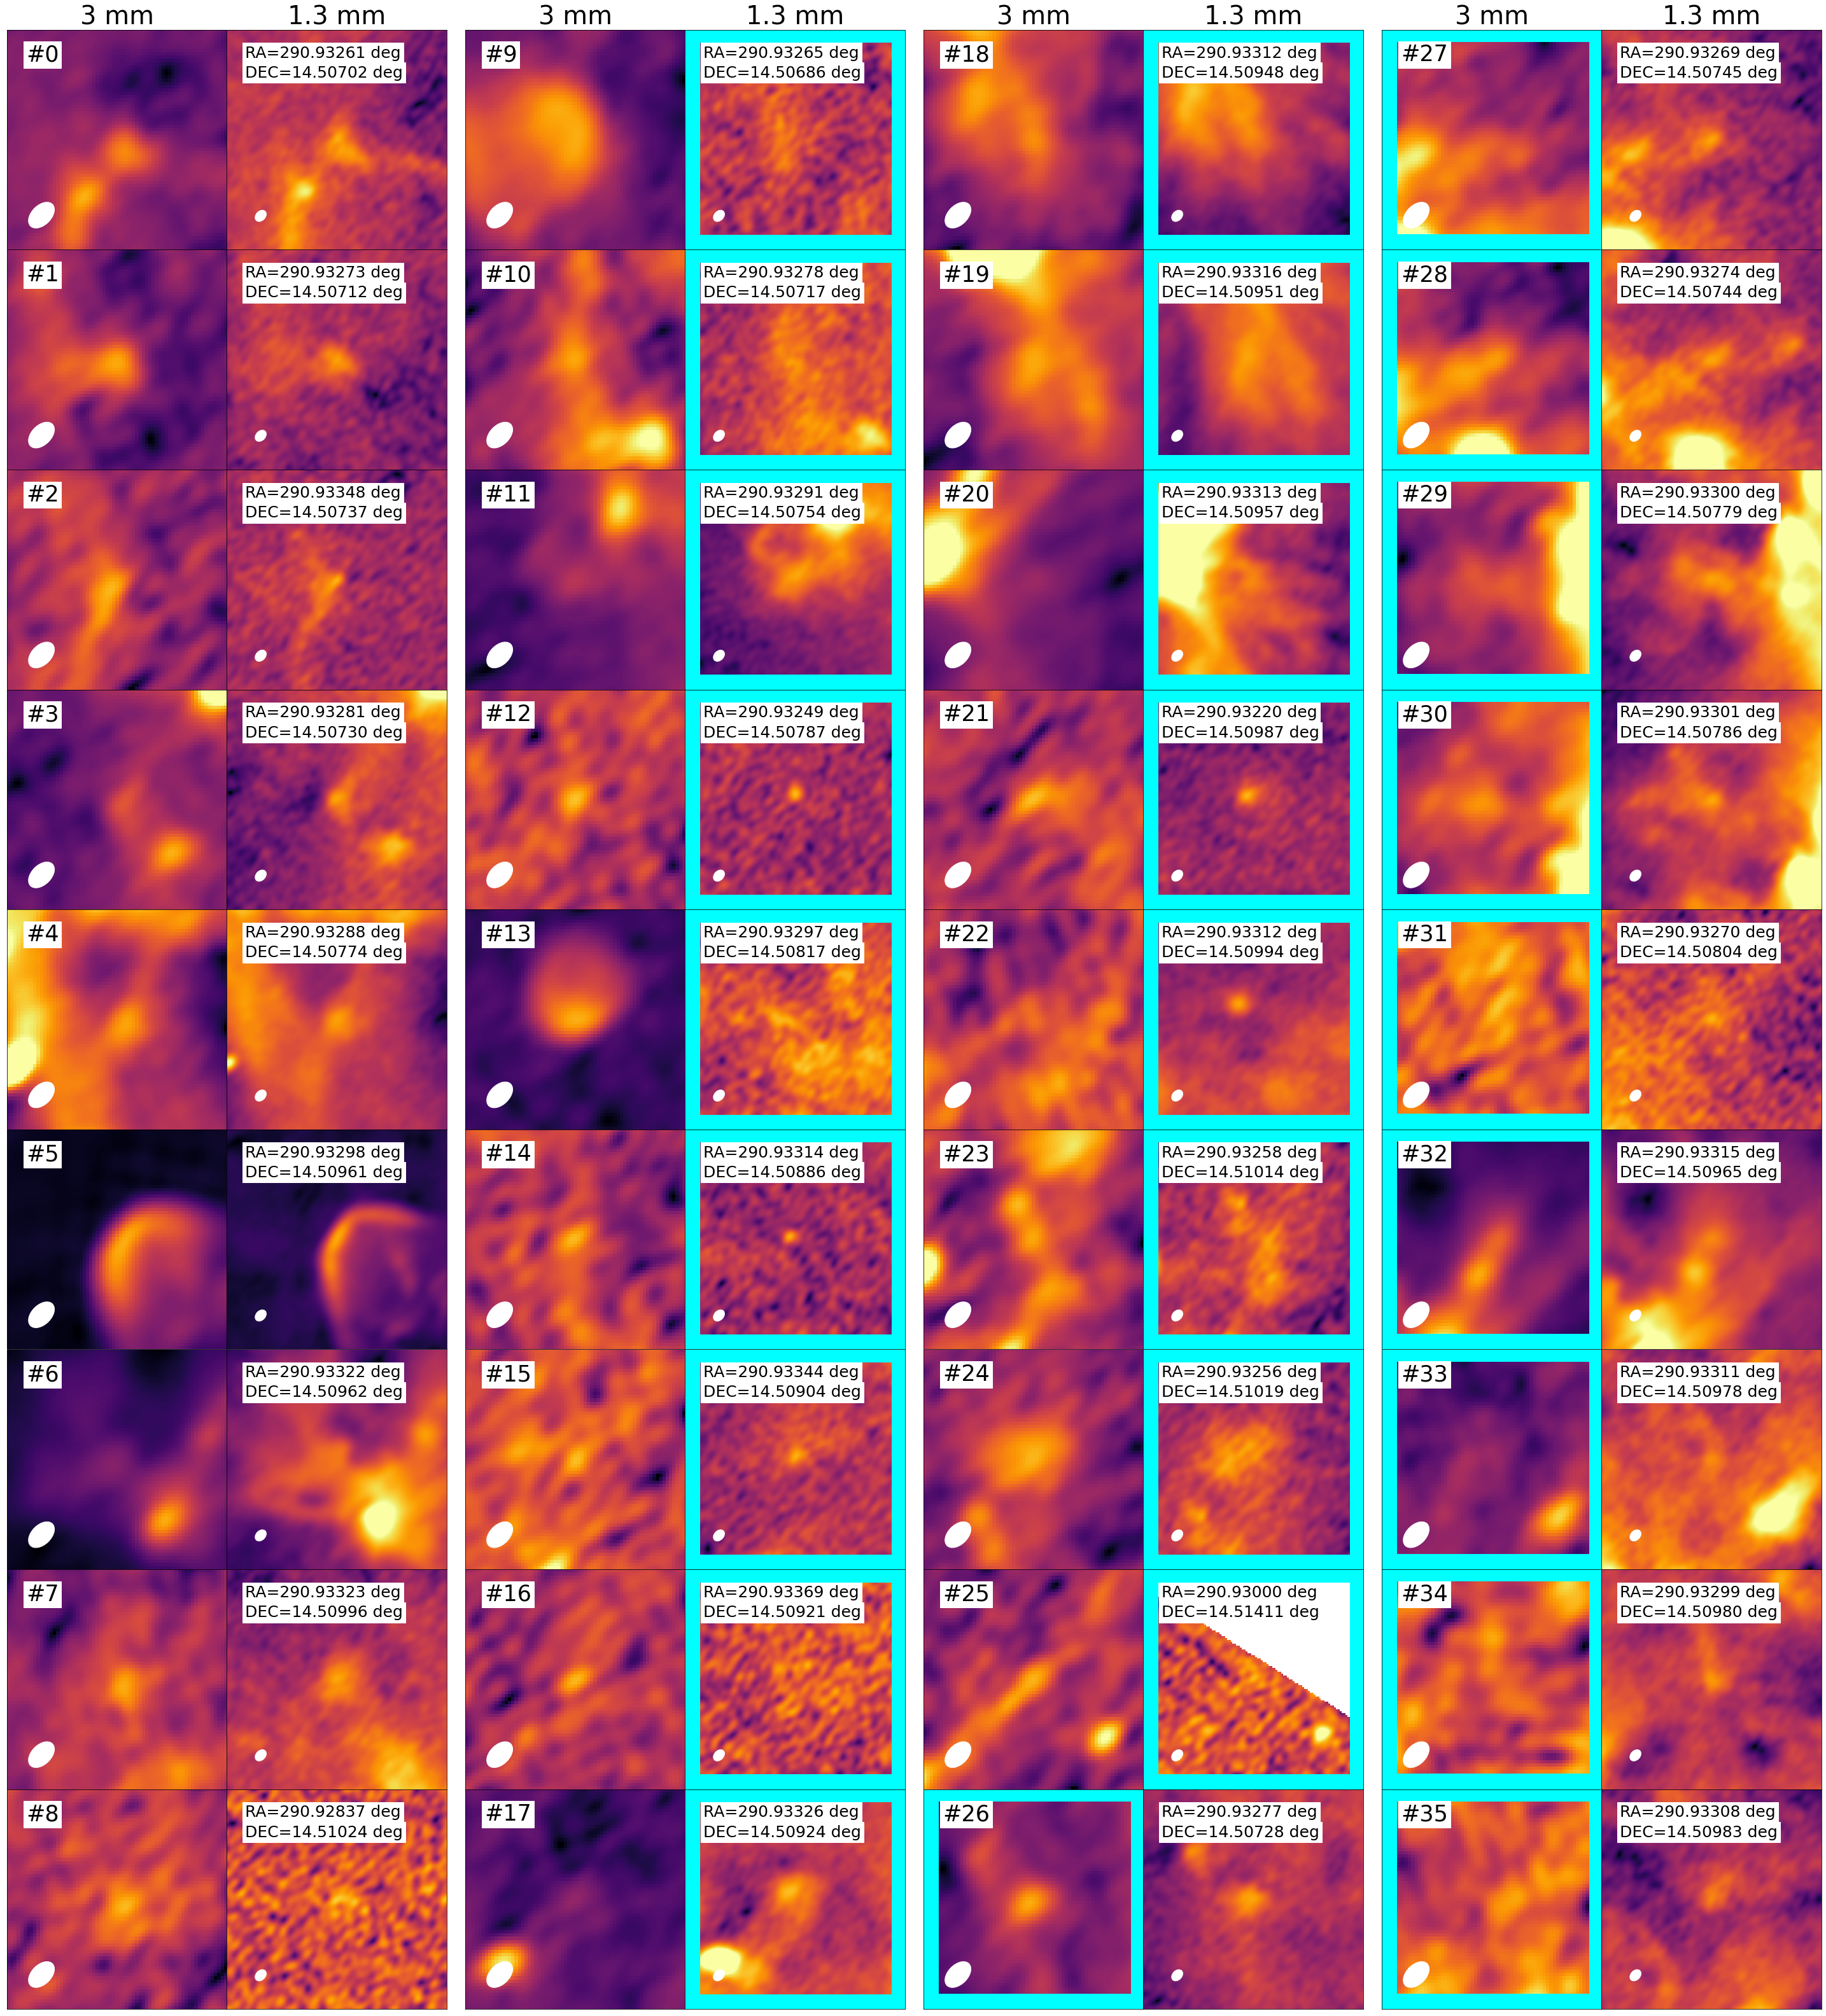

In [41]:
from astropy.table import Table
    
table_w51e = Table.read('tables/W51-E_ambiguous.fits')
print(len(table_w51e))

plot_set_cutouts(table_w51e, Path.w51e_b3_tt0, Path.w51e_b6_tt0,nrow=9,savedir='w51e_snapshot_ambiguous-1.png')



endnum 41
endendnum 45
obsnum 36
obsnum 37
obsnum 38
obsnum 39
obsnum 40
obsnum 41
obsnum 42
obsnum 43
obsnum_final, endnum 41 41
endnum 41
height 0.3033333333333333
top_add 0.3233333333333334
bottom_add 0.02000000000000013
margin 0.01
endnum 41
endendnum 45
arr [42 43 44]
ind, xind, yind 0 0 0
ind, xind, yind 1 1 0
ind, xind, yind 2 2 0
plot saved to  w51e_snapshot_ambiguous-2.png


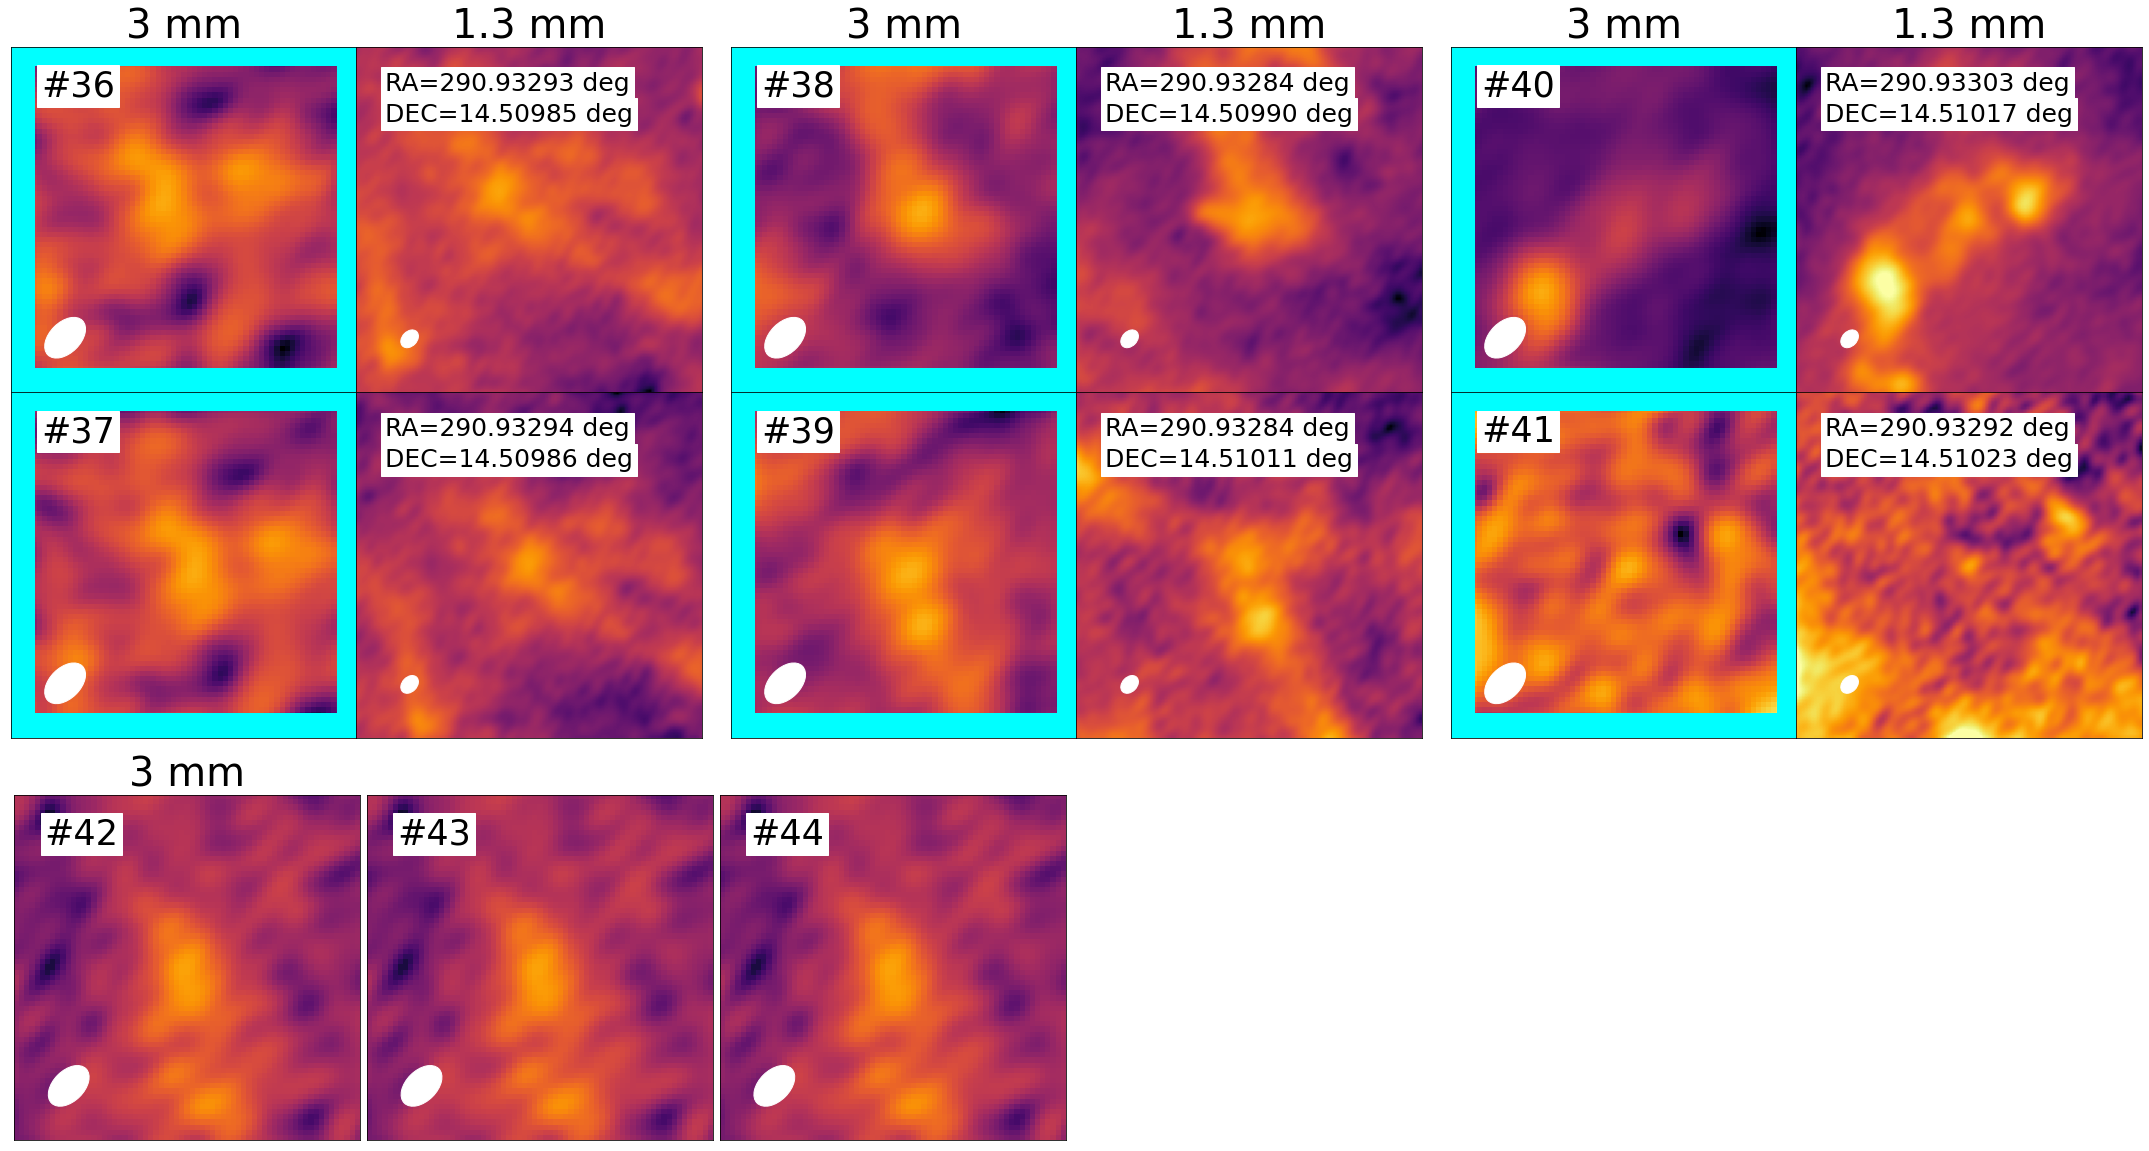

In [48]:
plot_set_cutouts(table_w51e, Path.w51e_b3_tt0, Path.w51e_b6_tt0,nrow=2,savedir='w51e_snapshot_ambiguous-2.png', startnum=36, endnum=41, additional_row=1)
